# Imports

In [0]:
from datetime import datetime, timedelta
from math import floor

import random
import numpy as np
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pyspark import SparkFiles
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, rand, day, month, window, monotonically_increasing_id
from pyspark.sql.types import StructType, StringType, TimestampType, StructField, IntegerType, FloatType

# Write test streaming dataset to file system to read them later to get streaming effect

In [0]:
data_schema = StructType([
        StructField("PosX", FloatType(), False),
        StructField("PosY", FloatType(), False),
        StructField("VelX", FloatType(), False),
        StructField("VelY", FloatType(), False),
        StructField("Action", StringType(), False)
])

streaming_schema = StructType([
        StructField("PosX", FloatType(), False),
        StructField("PosY", FloatType(), False),
        StructField("VelX", FloatType(), False),
        StructField("VelY", FloatType(), False),
        StructField("Action", StringType(), False),
        StructField("ActionIndex", FloatType(), False),
])

test_streaming_schema = StructType([
        StructField("PosX", FloatType(), False),
        StructField("PosY", FloatType(), False),
        StructField("VelX", FloatType(), False),
        StructField("VelY", FloatType(), False),
        StructField("Action", StringType(), False),
        StructField("ActionIndex", FloatType(), False),
        StructField("time_stamp", TimestampType(), False)
])
  

In [0]:
import urllib.request

train_url = "https://raw.githubusercontent.com/gazinaft/data-generation/master/data_train.csv"
test_url = "https://raw.githubusercontent.com/gazinaft/data-generation/master/data_test.csv"

train_file = "train_data.csv"
test_file = "test_data.csv"

urllib.request.urlretrieve(train_url, train_file)
urllib.request.urlretrieve(test_url, test_file)

('test_data.csv', <http.client.HTTPMessage at 0x7fdcf2f983d0>)

In [0]:
!readlink -f "train_data.csv"

/databricks/driver/train_data.csv


In [0]:
!readlink -f "test_data.csv"

/databricks/driver/test_data.csv


In [0]:
dictionary = {'none': 0, 'MoveLeft': 1, 'MoveRight': 2, 'Jump': 3}
numeric_labels = lambda x: dictionary[x]
udf_labels = udf(numeric_labels)

In [0]:
train_df = spark.read.schema(data_schema).csv("file:///databricks/driver/train_data.csv",header=False).withColumn("ActionIndex", udf_labels(col("Action"))).withColumn("ActionIndex", col("ActionIndex").cast(FloatType()))
test_df = spark.read.schema(data_schema).csv("file:///databricks/driver/test_data.csv",header=False).withColumn("ActionIndex", udf_labels(col("Action"))).withColumn("ActionIndex", col("ActionIndex").cast(FloatType()))

In [0]:
display(train_df)

PosX PosY VelX VelY Action ActionIndex 90.0 542.0 0.0 81.0 none 0.0 90.0 549.0 0.0 0.0 none 0.0 90.0 549.0 0.0 0.0 none 0.0 90.0 549.0 0.0 0.0 none 0.0 90.0 549.0 0.0 0.0 none 0.0 90.0 549.0 0.0 0.0 none 0.0 110.0 549.0 300.0 0.0 MoveRight 2.0 135.0 549.0 300.0 0.0 MoveRight 2.0 160.0 549.0 300.0 0.0 MoveRight 2.0 185.0 549.0 300.0 0.0 MoveRight 2.0 210.0 549.0 300.0 0.0 MoveRight 2.0 235.0 549.0 300.0 0.0 MoveRight 2.0 260.0 549.0 300.0 0.0 MoveRight 2.0 285.0 549.0 300.0 0.0 MoveRight 2.0 310.0 543.0 300.0 -400.0 MoveRight 2.0 335.0 514.0 300.0 -318.0 MoveRight 2.0 360.0 491.0 300.0 -236.0 MoveRight 2.0 385.0 475.0 300.0 -154.0 MoveRight 2.0 410.0 467.0 300.0 -73.0 MoveRight 2.0 435.0 465.0 300.0 8.0 MoveRight 2.0 460.0 469.0 300.0 90.0 MoveRight 2.0 475.0 481.0 0.0 171.0 none 0.0 475.0 489.0 0.0 0.0 none 0.0 495.0 489.0 300.0 0.0 MoveRight 2.0 520.0 489.0 300.0 0.0 MoveRight 2.0 545.0 464.0 300.0 -350.0 MoveRight 2.0 570.0 439.0 300.0 -269.0 MoveRight 2.0 595.0 421.0 300.0 -187.0 MoveRight 2.0 620.0 409.0 300.0 -105.0 MoveRight 2.0 645.0 405.0 300.0 -24.0 MoveRight 2.0 660.0 407.0 0.0 57.0 none 0.0 660.0 415.0 0.0 139.0 none 0.0 660.0 431.0 0.0 220.0 none 0.0 685.0 454.0 300.0 302.0 MoveRight 2.0 710.0 456.0 300.0 0.0 MoveRight 2.0 735.0 456.0 300.0 0.0 MoveRight 2.0 760.0 456.0 300.0 0.0 MoveRight 2.0 785.0 426.0 300.0 -334.0 MoveRight 2.0 798.0 402.0 0.0 -252.0 MoveRight 2.0 803.0 385.0 300.0 -171.0 MoveRight 2.0 828.0 375.0 300.0 -89.0 MoveRight 2.0 853.0 371.0 300.0 -7.0 MoveRight 2.0 878.0 375.0 300.0 73.0 MoveRight 2.0 903.0 385.0 300.0 155.0 MoveRight 2.0 928.0 389.0 300.0 0.0 MoveRight 2.0 918.0 389.0 -300.0 0.0 MoveLeft 1.0 893.0 389.0 -300.0 0.0 MoveLeft 1.0 868.0 389.0 -300.0 0.0 MoveLeft 1.0 843.0 364.0 -300.0 -350.0 MoveLeft 1.0 818.0 339.0 -300.0 -269.0 MoveLeft 1.0 793.0 321.0 -300.0 -187.0 MoveLeft 1.0 776.0 309.0 -300.0 -105.0 MoveLeft 1.0 751.0 305.0 -300.0 -24.0 MoveLeft 1.0 726.0 307.0 -300.0 57.0 MoveLeft 1.0 701.0 315.0 -300.0 139.0 MoveLeft 1.0 676.0 317.0 -300.0 0.0 MoveLeft 1.0 651.0 317.0 -300.0 0.0 MoveLeft 1.0 626.0 317.0 -300.0 0.0 MoveLeft 1.0 601.0 298.0 -300.0 -367.0 MoveLeft 1.0 576.0 272.0 -300.0 -285.0 MoveLeft 1.0 551.0 252.0 -300.0 -203.0 MoveLeft 1.0 526.0 239.0 -300.0 -122.0 MoveLeft 1.0 501.0 233.0 -300.0 -40.0 MoveLeft 1.0 476.0 234.0 -300.0 41.0 MoveLeft 1.0 451.0 241.0 -300.0 122.0 MoveLeft 1.0 426.0 255.0 -300.0 204.0 MoveLeft 1.0 401.0 277.0 -300.0 286.0 MoveLeft 1.0 376.0 304.0 -300.0 367.0 MoveLeft 1.0 351.0 339.0 -300.0 449.0 MoveLeft 1.0 326.0 381.0 -300.0 531.0 MoveLeft 1.0 301.0 429.0 -300.0 612.0 MoveLeft 1.0 276.0 484.0 -300.0 694.0 MoveLeft 1.0 251.0 546.0 -300.0 775.0 MoveLeft 1.0 226.0 549.0 -300.0 0.0 MoveLeft 1.0 201.0 549.0 -300.0 0.0 MoveLeft 1.0 176.0 549.0 -300.0 0.0 MoveLeft 1.0 186.0 549.0 300.0 0.0 MoveRight 2.0 211.0 549.0 300.0 0.0 MoveRight 2.0 236.0 549.0 300.0 0.0 MoveRight 2.0 261.0 549.0 300.0 0.0 MoveRight 2.0 286.0 549.0 300.0 0.0 MoveRight 2.0 311.0 549.0 300.0 0.0 MoveRight 2.0 336.0 524.0 300.0 -350.0 MoveRight 2.0 361.0 499.0 300.0 -269.0 MoveRight 2.0 386.0 481.0 300.0 -187.0 MoveRight 2.0 411.0 469.0 300.0 -105.0 MoveRight 2.0 411.0 465.0 0.0 -24.0 none 0.0 426.0 467.0 300.0 57.0 MoveRight 2.0 451.0 475.0 300.0 139.0 MoveRight 2.0 476.0 489.0 300.0 0.0 MoveRight 2.0 501.0 489.0 300.0 0.0 MoveRight 2.0 526.0 489.0 300.0 0.0 MoveRight 2.0 551.0 470.0 300.0 -367.0 MoveRight 2.0 576.0 444.0 300.0 -285.0 MoveRight 2.0 601.0 424.0 300.0 -203.0 MoveRight 2.0 621.0 411.0 0.0 -122.0 none 0.0 621.0 405.0 0.0 -40.0 none 0.0 636.0 406.0 300.0 41.0 MoveRight 2.0 661.0 413.0 300.0 122.0 MoveRight 2.0 681.0 427.0 0.0 204.0 none 0.0 681.0 449.0 0.0 286.0 none 0.0 681.0 456.0 0.0 0.0 none 0.0 681.0 456.0 0.0 0.0 none 0.0 696.0 456.0 300.0 0.0 MoveRight 2.0 721.0 437.0 300.0 -367.0 MoveRight 2.0 746.0 411.0 300.0 -285.0 MoveRight 2.0 771.0 405.0 300.0 49.0 MoveRight 2.0 796.0 413.0 300.0 130.0 MoveRight 2.0 798.0 428.0 0.0 212.0 MoveRight 2.0 798.0 450.0 0.0 294.

In [0]:
display(test_df)

PosX PosY VelX VelY Action ActionIndex 90.0 542.0 0.0 81.0 none 0.0 90.0 549.0 0.0 0.0 none 0.0 90.0 549.0 0.0 0.0 none 0.0 90.0 549.0 0.0 0.0 none 0.0 90.0 549.0 0.0 0.0 none 0.0 110.0 549.0 300.0 0.0 MoveRight 2.0 135.0 549.0 300.0 0.0 MoveRight 2.0 160.0 549.0 300.0 0.0 MoveRight 2.0 185.0 549.0 300.0 0.0 MoveRight 2.0 210.0 549.0 300.0 0.0 MoveRight 2.0 235.0 549.0 300.0 0.0 MoveRight 2.0 260.0 549.0 300.0 0.0 MoveRight 2.0 285.0 543.0 300.0 -400.0 MoveRight 2.0 310.0 514.0 300.0 -318.0 MoveRight 2.0 335.0 491.0 300.0 -236.0 MoveRight 2.0 360.0 475.0 300.0 -154.0 MoveRight 2.0 385.0 467.0 300.0 -73.0 MoveRight 2.0 410.0 465.0 300.0 8.0 MoveRight 2.0 435.0 469.0 300.0 90.0 MoveRight 2.0 460.0 481.0 300.0 171.0 MoveRight 2.0 485.0 489.0 300.0 0.0 MoveRight 2.0 510.0 476.0 300.0 -383.0 MoveRight 2.0 535.0 448.0 300.0 -301.0 MoveRight 2.0 560.0 427.0 300.0 -220.0 MoveRight 2.0 585.0 413.0 300.0 -138.0 MoveRight 2.0 610.0 406.0 300.0 -56.0 MoveRight 2.0 635.0 405.0 300.0 24.0 MoveRight 2.0 660.0 411.0 300.0 106.0 MoveRight 2.0 685.0 424.0 300.0 188.0 MoveRight 2.0 710.0 444.0 300.0 269.0 MoveRight 2.0 735.0 450.0 300.0 -400.0 MoveRight 2.0 760.0 421.0 300.0 -318.0 MoveRight 2.0 785.0 404.0 300.0 16.0 MoveRight 2.0 798.0 409.0 0.0 98.0 MoveRight 2.0 798.0 422.0 0.0 179.0 MoveRight 2.0 798.0 441.0 0.0 261.0 MoveRight 2.0 798.0 456.0 0.0 0.0 MoveRight 2.0 798.0 456.0 0.0 0.0 MoveRight 2.0 798.0 437.0 0.0 -367.0 MoveRight 2.0 798.0 411.0 0.0 -285.0 MoveRight 2.0 798.0 391.0 0.0 -203.0 MoveRight 2.0 818.0 378.0 300.0 -122.0 MoveRight 2.0 843.0 372.0 300.0 -40.0 MoveRight 2.0 868.0 373.0 300.0 41.0 MoveRight 2.0 893.0 380.0 300.0 122.0 MoveRight 2.0 913.0 389.0 0.0 0.0 none 0.0 888.0 389.0 -300.0 0.0 MoveLeft 1.0 863.0 364.0 -300.0 -350.0 MoveLeft 1.0 838.0 339.0 -300.0 -269.0 MoveLeft 1.0 813.0 321.0 -300.0 -187.0 MoveLeft 1.0 788.0 309.0 -300.0 -105.0 MoveLeft 1.0 763.0 305.0 -300.0 -24.0 MoveLeft 1.0 738.0 307.0 -300.0 57.0 MoveLeft 1.0 713.0 315.0 -300.0 139.0 MoveLeft 1.0 688.0 317.0 -300.0 0.0 MoveLeft 1.0 663.0 317.0 -300.0 0.0 MoveLeft 1.0 638.0 298.0 -300.0 -367.0 MoveLeft 1.0 613.0 272.0 -300.0 -285.0 MoveLeft 1.0 588.0 252.0 -300.0 -203.0 MoveLeft 1.0 563.0 239.0 -300.0 -122.0 MoveLeft 1.0 538.0 233.0 -300.0 -40.0 MoveLeft 1.0 513.0 234.0 -300.0 41.0 MoveLeft 1.0 488.0 241.0 -300.0 122.0 MoveLeft 1.0 463.0 255.0 -300.0 204.0 MoveLeft 1.0 438.0 277.0 -300.0 286.0 MoveLeft 1.0 413.0 304.0 -300.0 367.0 MoveLeft 1.0 388.0 339.0 -300.0 449.0 MoveLeft 1.0 363.0 381.0 -300.0 531.0 MoveLeft 1.0 338.0 429.0 -300.0 612.0 MoveLeft 1.0 313.0 484.0 -300.0 694.0 MoveLeft 1.0 313.0 546.0 300.0 775.0 MoveRight 2.0 338.0 549.0 300.0 0.0 MoveRight 2.0 363.0 519.0 300.0 -334.0 MoveRight 2.0 388.0 495.0 300.0 -252.0 MoveRight 2.0 413.0 478.0 300.0 -171.0 MoveRight 2.0 438.0 468.0 300.0 -89.0 MoveRight 2.0 463.0 464.0 300.0 -7.0 MoveRight 2.0 488.0 468.0 300.0 73.0 MoveRight 2.0 513.0 478.0 300.0 155.0 MoveRight 2.0 538.0 489.0 300.0 0.0 MoveRight 2.0 563.0 489.0 300.0 0.0 MoveRight 2.0 588.0 489.0 300.0 0.0 MoveRight 2.0 613.0 489.0 300.0 0.0 MoveRight 2.0 617.0 489.0 0.0 0.0 MoveRight 2.0 617.0 470.0 0.0 -367.0 MoveRight 2.0 627.0 444.0 300.0 -285.0 MoveRight 2.0 652.0 424.0 300.0 -203.0 MoveRight 2.0 677.0 411.0 300.0 -122.0 MoveRight 2.0 702.0 405.0 300.0 -40.0 MoveRight 2.0 722.0 406.0 0.0 41.0 none 0.0 722.0 413.0 0.0 122.0 none 0.0 722.0 427.0 0.0 204.0 none 0.0 722.0 449.0 0.0 286.0 none 0.0 732.0 456.0 300.0 0.0 MoveRight 2.0 757.0 456.0 300.0 0.0 MoveRight 2.0 782.0 450.0 300.0 -400.0 MoveRight 2.0 798.0 421.0 0.0 -318.0 MoveRight 2.0 798.0 398.0 0.0 -236.0 MoveRight 2.0 808.0 382.0 300.0 -154.0 MoveRight 2.0 833.0 374.0 300.0 -73.0 MoveRight 2.0 858.0 372.0 300.0 8.0 MoveRight 2.0 883.0 376.0 300.0 90.0 MoveRight 2.0 868.0 388.0 -300.0 171.0 MoveLeft 1.0 843.0 389.0 -300.0 0.0 MoveLeft 1.0 818.0 376.0 -300.0 -383.0 MoveLeft 1.0 793.0 348.0 -300.0 -301.0 MoveLeft 1.0 791.0 327.0 0.0 -220.0 MoveLeft 1.0 786.0 313.0 -300.0 -138.0 MoveL

In [0]:
! rm -rf /dbfs/FileStore/datasets


# Write data to filesystem

In [0]:
def simulated_timestamps(index):
    now = datetime.now()
    result = []
    for i in index:
        result.append(now - timedelta(seconds=20)+ timedelta(seconds=floor(i / 50), milliseconds=random.randint(0, 999)))
    return result

In [0]:
! rm -rf /dbfs/FileStore/datasets
! mkdir -p /dbfs/FileStore/datasets
! mkdir -p /dbfs/FileStore/datasets/train
! mkdir -p /dbfs/FileStore/datasets/test


filename = "/dbfs/FileStore/datasets/train/course_work.csv"
filename2 = "/dbfs/FileStore/datasets/test/course_work.csv"
train_df.toPandas().to_csv(filename, index=False)
spark.sparkContext.addFile(filename)

timestamped = test_df.toPandas().sample(frac = 1).reset_index(drop=True).assign(time_stamp=lambda x: simulated_timestamps(x.index))
timestamped.to_csv(filename2, index=False)
spark.sparkContext.addFile(filename2)

!ls /dbfs/FileStore/datasets/

test  train


In [0]:
display(timestamped)

PosX PosY VelX VelY Action ActionIndex time_stamp 411.0 478.0 300.0 -171.0 MoveRight 2.0 2024-01-05T20:14:34.839207Z 286.0 484.0 -300.0 694.0 MoveLeft 1.0 2024-01-05T20:14:33.971207Z 558.0 272.0 -300.0 -285.0 MoveLeft 1.0 2024-01-05T20:14:34.746207Z 768.0 306.0 -300.0 41.0 MoveLeft 1.0 2024-01-05T20:14:34.327207Z 228.0 549.0 0.0 0.0 none 0.0 2024-01-05T20:14:34.945207Z 263.0 549.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.227207Z 711.0 424.0 300.0 188.0 MoveRight 2.0 2024-01-05T20:14:34.884207Z 798.0 394.0 0.0 -220.0 MoveRight 2.0 2024-01-05T20:14:34.219207Z 692.0 456.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.025207Z 893.0 389.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.323207Z 443.0 255.0 -300.0 204.0 MoveLeft 1.0 2024-01-05T20:14:34.517207Z 487.0 465.0 300.0 -24.0 MoveRight 2.0 2024-01-05T20:14:34.659207Z 576.0 427.0 300.0 -220.0 MoveRight 2.0 2024-01-05T20:14:34.512207Z 563.0 489.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.436207Z 543.0 470.0 300.0 -367.0 MoveRight 2.0 2024-01-05T20:14:34.625207Z 793.0 305.0 -300.0 -40.0 MoveLeft 1.0 2024-01-05T20:14:34.006207Z 428.0 473.0 300.0 -138.0 MoveRight 2.0 2024-01-05T20:14:34.222207Z 488.0 475.0 300.0 139.0 MoveRight 2.0 2024-01-05T20:14:34.740207Z 523.0 234.0 -300.0 -56.0 MoveLeft 1.0 2024-01-05T20:14:34.768207Z 737.0 408.0 300.0 73.0 MoveRight 2.0 2024-01-05T20:14:34.146207Z 793.0 305.0 -300.0 -24.0 MoveLeft 1.0 2024-01-05T20:14:34.542207Z 238.0 549.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.456207Z 743.0 313.0 -300.0 122.0 MoveLeft 1.0 2024-01-05T20:14:34.733207Z 263.0 549.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.856207Z 707.0 421.0 300.0 171.0 MoveRight 2.0 2024-01-05T20:14:34.396207Z 647.0 418.0 300.0 -171.0 MoveRight 2.0 2024-01-05T20:14:34.917207Z 228.0 549.0 -300.0 0.0 MoveLeft 1.0 2024-01-05T20:14:34.692207Z 296.0 549.0 0.0 0.0 none 0.0 2024-01-05T20:14:34.850207Z 561.0 252.0 -300.0 -203.0 MoveLeft 1.0 2024-01-05T20:14:34.859207Z 351.0 363.0 -300.0 498.0 MoveLeft 1.0 2024-01-05T20:14:34.505207Z 833.0 389.0 0.0 0.0 none 0.0 2024-01-05T20:14:34.020207Z 712.0 444.0 300.0 269.0 MoveRight 2.0 2024-01-05T20:14:34.764207Z 687.0 408.0 300.0 -89.0 MoveRight 2.0 2024-01-05T20:14:34.106207Z 253.0 549.0 -300.0 0.0 MoveLeft 1.0 2024-01-05T20:14:34.121207Z 568.0 252.0 -300.0 -203.0 MoveLeft 1.0 2024-01-05T20:14:34.903207Z 711.0 456.0 0.0 0.0 none 0.0 2024-01-05T20:14:34.390207Z 761.0 306.0 -300.0 -56.0 MoveLeft 1.0 2024-01-05T20:14:34.558207Z 553.0 489.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.657207Z 798.0 431.0 0.0 -350.0 none 0.0 2024-01-05T20:14:34.200207Z 743.0 307.0 -300.0 57.0 MoveLeft 1.0 2024-01-05T20:14:34.119207Z 768.0 307.0 -300.0 57.0 MoveLeft 1.0 2024-01-05T20:14:34.377207Z 353.0 325.0 -300.0 416.0 MoveLeft 1.0 2024-01-05T20:14:34.283207Z 160.0 549.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.036207Z 798.0 408.0 0.0 81.0 MoveRight 2.0 2024-01-05T20:14:34.769207Z 301.0 549.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.204207Z 563.0 459.0 300.0 -334.0 MoveRight 2.0 2024-01-05T20:14:34.313207Z 233.0 546.0 -300.0 775.0 MoveLeft 1.0 2024-01-05T20:14:34.814207Z 438.0 277.0 -300.0 286.0 MoveLeft 1.0 2024-01-05T20:14:33.959207Z 578.0 282.0 -300.0 -318.0 MoveLeft 1.0 2024-01-05T20:14:34.196207Z 648.0 317.0 -300.0 0.0 MoveLeft 1.0 2024-01-05T20:14:34.453207Z 768.0 307.0 -300.0 -73.0 MoveLeft 1.0 2024-01-05T20:14:35.896207Z 973.0 389.0 0.0 0.0 none 0.0 2024-01-05T20:14:35.934207Z 321.0 381.0 -300.0 531.0 MoveLeft 1.0 2024-01-05T20:14:35.288207Z 848.0 344.0 -300.0 -285.0 MoveLeft 1.0 2024-01-05T20:14:35.400207Z 968.0 389.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:35.339207Z 178.0 549.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:35.905207Z 286.0 546.0 300.0 775.0 MoveRight 2.0 2024-01-05T20:14:35.696207Z 271.0 521.0 0.0 743.0 none 0.0 2024-01-05T20:14:35.814207Z 888.0 389.0 -300.0 0.0 MoveLeft 1.0 2024-01-05T20:14:35.198207Z 601.0 413.0 300.0 -138.0 MoveRight 2.0 2024-01-05T20:14:35.819207Z 303.0 549.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:35.771207Z 623.0 252.

In [0]:
def visualize_coordinates(df):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    plt.scatter(df.toPandas()['PosX'], df.toPandas()['PosY'], c ="blue")

    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    plt.show()

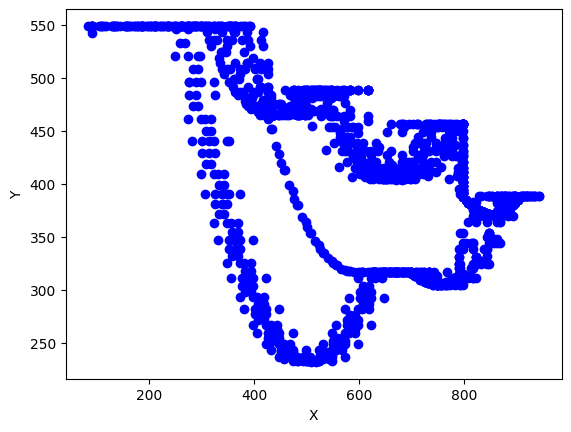

In [0]:
visualize_coordinates(train_df)

# Start streaming

In [0]:
train_files = "/dbfs/FileStore/datasets/train/"

streaming_train = (
    spark
    .readStream
    .format("csv")
    .schema(streaming_schema)
    .option("header", "True")
    .option("maxFilesPerTrigger", 1)
    .load("file://" + train_files)
)

In [0]:
display(streaming_train)

PosX PosY VelX VelY Action ActionIndex 90.0 542.0 0.0 81.0 none 0.0 90.0 549.0 0.0 0.0 none 0.0 90.0 549.0 0.0 0.0 none 0.0 90.0 549.0 0.0 0.0 none 0.0 90.0 549.0 0.0 0.0 none 0.0 90.0 549.0 0.0 0.0 none 0.0 110.0 549.0 300.0 0.0 MoveRight 2.0 135.0 549.0 300.0 0.0 MoveRight 2.0 160.0 549.0 300.0 0.0 MoveRight 2.0 185.0 549.0 300.0 0.0 MoveRight 2.0 210.0 549.0 300.0 0.0 MoveRight 2.0 235.0 549.0 300.0 0.0 MoveRight 2.0 260.0 549.0 300.0 0.0 MoveRight 2.0 285.0 549.0 300.0 0.0 MoveRight 2.0 310.0 543.0 300.0 -400.0 MoveRight 2.0 335.0 514.0 300.0 -318.0 MoveRight 2.0 360.0 491.0 300.0 -236.0 MoveRight 2.0 385.0 475.0 300.0 -154.0 MoveRight 2.0 410.0 467.0 300.0 -73.0 MoveRight 2.0 435.0 465.0 300.0 8.0 MoveRight 2.0 460.0 469.0 300.0 90.0 MoveRight 2.0 475.0 481.0 0.0 171.0 none 0.0 475.0 489.0 0.0 0.0 none 0.0 495.0 489.0 300.0 0.0 MoveRight 2.0 520.0 489.0 300.0 0.0 MoveRight 2.0 545.0 464.0 300.0 -350.0 MoveRight 2.0 570.0 439.0 300.0 -269.0 MoveRight 2.0 595.0 421.0 300.0 -187.0 MoveRight 2.0 620.0 409.0 300.0 -105.0 MoveRight 2.0 645.0 405.0 300.0 -24.0 MoveRight 2.0 660.0 407.0 0.0 57.0 none 0.0 660.0 415.0 0.0 139.0 none 0.0 660.0 431.0 0.0 220.0 none 0.0 685.0 454.0 300.0 302.0 MoveRight 2.0 710.0 456.0 300.0 0.0 MoveRight 2.0 735.0 456.0 300.0 0.0 MoveRight 2.0 760.0 456.0 300.0 0.0 MoveRight 2.0 785.0 426.0 300.0 -334.0 MoveRight 2.0 798.0 402.0 0.0 -252.0 MoveRight 2.0 803.0 385.0 300.0 -171.0 MoveRight 2.0 828.0 375.0 300.0 -89.0 MoveRight 2.0 853.0 371.0 300.0 -7.0 MoveRight 2.0 878.0 375.0 300.0 73.0 MoveRight 2.0 903.0 385.0 300.0 155.0 MoveRight 2.0 928.0 389.0 300.0 0.0 MoveRight 2.0 918.0 389.0 -300.0 0.0 MoveLeft 1.0 893.0 389.0 -300.0 0.0 MoveLeft 1.0 868.0 389.0 -300.0 0.0 MoveLeft 1.0 843.0 364.0 -300.0 -350.0 MoveLeft 1.0 818.0 339.0 -300.0 -269.0 MoveLeft 1.0 793.0 321.0 -300.0 -187.0 MoveLeft 1.0 776.0 309.0 -300.0 -105.0 MoveLeft 1.0 751.0 305.0 -300.0 -24.0 MoveLeft 1.0 726.0 307.0 -300.0 57.0 MoveLeft 1.0 701.0 315.0 -300.0 139.0 MoveLeft 1.0 676.0 317.0 -300.0 0.0 MoveLeft 1.0 651.0 317.0 -300.0 0.0 MoveLeft 1.0 626.0 317.0 -300.0 0.0 MoveLeft 1.0 601.0 298.0 -300.0 -367.0 MoveLeft 1.0 576.0 272.0 -300.0 -285.0 MoveLeft 1.0 551.0 252.0 -300.0 -203.0 MoveLeft 1.0 526.0 239.0 -300.0 -122.0 MoveLeft 1.0 501.0 233.0 -300.0 -40.0 MoveLeft 1.0 476.0 234.0 -300.0 41.0 MoveLeft 1.0 451.0 241.0 -300.0 122.0 MoveLeft 1.0 426.0 255.0 -300.0 204.0 MoveLeft 1.0 401.0 277.0 -300.0 286.0 MoveLeft 1.0 376.0 304.0 -300.0 367.0 MoveLeft 1.0 351.0 339.0 -300.0 449.0 MoveLeft 1.0 326.0 381.0 -300.0 531.0 MoveLeft 1.0 301.0 429.0 -300.0 612.0 MoveLeft 1.0 276.0 484.0 -300.0 694.0 MoveLeft 1.0 251.0 546.0 -300.0 775.0 MoveLeft 1.0 226.0 549.0 -300.0 0.0 MoveLeft 1.0 201.0 549.0 -300.0 0.0 MoveLeft 1.0 176.0 549.0 -300.0 0.0 MoveLeft 1.0 186.0 549.0 300.0 0.0 MoveRight 2.0 211.0 549.0 300.0 0.0 MoveRight 2.0 236.0 549.0 300.0 0.0 MoveRight 2.0 261.0 549.0 300.0 0.0 MoveRight 2.0 286.0 549.0 300.0 0.0 MoveRight 2.0 311.0 549.0 300.0 0.0 MoveRight 2.0 336.0 524.0 300.0 -350.0 MoveRight 2.0 361.0 499.0 300.0 -269.0 MoveRight 2.0 386.0 481.0 300.0 -187.0 MoveRight 2.0 411.0 469.0 300.0 -105.0 MoveRight 2.0 411.0 465.0 0.0 -24.0 none 0.0 426.0 467.0 300.0 57.0 MoveRight 2.0 451.0 475.0 300.0 139.0 MoveRight 2.0 476.0 489.0 300.0 0.0 MoveRight 2.0 501.0 489.0 300.0 0.0 MoveRight 2.0 526.0 489.0 300.0 0.0 MoveRight 2.0 551.0 470.0 300.0 -367.0 MoveRight 2.0 576.0 444.0 300.0 -285.0 MoveRight 2.0 601.0 424.0 300.0 -203.0 MoveRight 2.0 621.0 411.0 0.0 -122.0 none 0.0 621.0 405.0 0.0 -40.0 none 0.0 636.0 406.0 300.0 41.0 MoveRight 2.0 661.0 413.0 300.0 122.0 MoveRight 2.0 681.0 427.0 0.0 204.0 none 0.0 681.0 449.0 0.0 286.0 none 0.0 681.0 456.0 0.0 0.0 none 0.0 681.0 456.0 0.0 0.0 none 0.0 696.0 456.0 300.0 0.0 MoveRight 2.0 721.0 437.0 300.0 -367.0 MoveRight 2.0 746.0 411.0 300.0 -285.0 MoveRight 2.0 771.0 405.0 300.0 49.0 MoveRight 2.0 796.0 413.0 300.0 130.0 MoveRight 2.0 798.0 428.0 0.0 212.0 MoveRight 2.0 798.0 450.0 0.0 294.

In [0]:
test_files = "/dbfs/FileStore/datasets/test/"

streaming_test = (
    spark
    .readStream
    .format("csv")
    .schema(test_streaming_schema)
    .option("header", "True")
    .option("maxFilesPerTrigger", 1)
    .load("file://" + test_files)
)

In [0]:
display(streaming_test)

PosX PosY VelX VelY Action ActionIndex time_stamp 411.0 478.0 300.0 -171.0 MoveRight 2.0 2024-01-05T20:14:34.839207Z 286.0 484.0 -300.0 694.0 MoveLeft 1.0 2024-01-05T20:14:33.971207Z 558.0 272.0 -300.0 -285.0 MoveLeft 1.0 2024-01-05T20:14:34.746207Z 768.0 306.0 -300.0 41.0 MoveLeft 1.0 2024-01-05T20:14:34.327207Z 228.0 549.0 0.0 0.0 none 0.0 2024-01-05T20:14:34.945207Z 263.0 549.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.227207Z 711.0 424.0 300.0 188.0 MoveRight 2.0 2024-01-05T20:14:34.884207Z 798.0 394.0 0.0 -220.0 MoveRight 2.0 2024-01-05T20:14:34.219207Z 692.0 456.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.025207Z 893.0 389.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.323207Z 443.0 255.0 -300.0 204.0 MoveLeft 1.0 2024-01-05T20:14:34.517207Z 487.0 465.0 300.0 -24.0 MoveRight 2.0 2024-01-05T20:14:34.659207Z 576.0 427.0 300.0 -220.0 MoveRight 2.0 2024-01-05T20:14:34.512207Z 563.0 489.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.436207Z 543.0 470.0 300.0 -367.0 MoveRight 2.0 2024-01-05T20:14:34.625207Z 793.0 305.0 -300.0 -40.0 MoveLeft 1.0 2024-01-05T20:14:34.006207Z 428.0 473.0 300.0 -138.0 MoveRight 2.0 2024-01-05T20:14:34.222207Z 488.0 475.0 300.0 139.0 MoveRight 2.0 2024-01-05T20:14:34.740207Z 523.0 234.0 -300.0 -56.0 MoveLeft 1.0 2024-01-05T20:14:34.768207Z 737.0 408.0 300.0 73.0 MoveRight 2.0 2024-01-05T20:14:34.146207Z 793.0 305.0 -300.0 -24.0 MoveLeft 1.0 2024-01-05T20:14:34.542207Z 238.0 549.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.456207Z 743.0 313.0 -300.0 122.0 MoveLeft 1.0 2024-01-05T20:14:34.733207Z 263.0 549.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.856207Z 707.0 421.0 300.0 171.0 MoveRight 2.0 2024-01-05T20:14:34.396207Z 647.0 418.0 300.0 -171.0 MoveRight 2.0 2024-01-05T20:14:34.917207Z 228.0 549.0 -300.0 0.0 MoveLeft 1.0 2024-01-05T20:14:34.692207Z 296.0 549.0 0.0 0.0 none 0.0 2024-01-05T20:14:34.850207Z 561.0 252.0 -300.0 -203.0 MoveLeft 1.0 2024-01-05T20:14:34.859207Z 351.0 363.0 -300.0 498.0 MoveLeft 1.0 2024-01-05T20:14:34.505207Z 833.0 389.0 0.0 0.0 none 0.0 2024-01-05T20:14:34.020207Z 712.0 444.0 300.0 269.0 MoveRight 2.0 2024-01-05T20:14:34.764207Z 687.0 408.0 300.0 -89.0 MoveRight 2.0 2024-01-05T20:14:34.106207Z 253.0 549.0 -300.0 0.0 MoveLeft 1.0 2024-01-05T20:14:34.121207Z 568.0 252.0 -300.0 -203.0 MoveLeft 1.0 2024-01-05T20:14:34.903207Z 711.0 456.0 0.0 0.0 none 0.0 2024-01-05T20:14:34.390207Z 761.0 306.0 -300.0 -56.0 MoveLeft 1.0 2024-01-05T20:14:34.558207Z 553.0 489.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.657207Z 798.0 431.0 0.0 -350.0 none 0.0 2024-01-05T20:14:34.200207Z 743.0 307.0 -300.0 57.0 MoveLeft 1.0 2024-01-05T20:14:34.119207Z 768.0 307.0 -300.0 57.0 MoveLeft 1.0 2024-01-05T20:14:34.377207Z 353.0 325.0 -300.0 416.0 MoveLeft 1.0 2024-01-05T20:14:34.283207Z 160.0 549.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.036207Z 798.0 408.0 0.0 81.0 MoveRight 2.0 2024-01-05T20:14:34.769207Z 301.0 549.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.204207Z 563.0 459.0 300.0 -334.0 MoveRight 2.0 2024-01-05T20:14:34.313207Z 233.0 546.0 -300.0 775.0 MoveLeft 1.0 2024-01-05T20:14:34.814207Z 438.0 277.0 -300.0 286.0 MoveLeft 1.0 2024-01-05T20:14:33.959207Z 578.0 282.0 -300.0 -318.0 MoveLeft 1.0 2024-01-05T20:14:34.196207Z 648.0 317.0 -300.0 0.0 MoveLeft 1.0 2024-01-05T20:14:34.453207Z 768.0 307.0 -300.0 -73.0 MoveLeft 1.0 2024-01-05T20:14:35.896207Z 973.0 389.0 0.0 0.0 none 0.0 2024-01-05T20:14:35.934207Z 321.0 381.0 -300.0 531.0 MoveLeft 1.0 2024-01-05T20:14:35.288207Z 848.0 344.0 -300.0 -285.0 MoveLeft 1.0 2024-01-05T20:14:35.400207Z 968.0 389.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:35.339207Z 178.0 549.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:35.905207Z 286.0 546.0 300.0 775.0 MoveRight 2.0 2024-01-05T20:14:35.696207Z 271.0 521.0 0.0 743.0 none 0.0 2024-01-05T20:14:35.814207Z 888.0 389.0 -300.0 0.0 MoveLeft 1.0 2024-01-05T20:14:35.198207Z 601.0 413.0 300.0 -138.0 MoveRight 2.0 2024-01-05T20:14:35.819207Z 303.0 549.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:35.771207Z 623.0 252.

# Classification

In [0]:
vector_assembler = VectorAssembler(inputCols=['PosX', 'PosY', 'VelX', 'VelY'], outputCol='features')


In [0]:
target_column = 'ActionIndex'
vectorized = vector_assembler.transform(train_df)

(training_data, validation_data) = vectorized.randomSplit([0.8, 0.2], seed=42)
classifier = RandomForestClassifier(labelCol="ActionIndex", featuresCol='features', numTrees=10)
model = classifier.fit(training_data)

predictions = model.transform(validation_data)

evaluator = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

print("Accuracy: " + str(accuracy))


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Accuracy: 0.9841897233201581


In [0]:
def prediction_correctness(real, prediction):
    if int(real) == int(prediction):
        return 1.0
    else:
        return 0.0

get_correctness = udf(prediction_correctness)

In [0]:
vectorized_streaming = vector_assembler.transform(streaming_test)
display(vectorized_streaming)

PosX PosY VelX VelY Action ActionIndex time_stamp features 411.0 478.0 300.0 -171.0 MoveRight 2.0 2024-01-05T20:14:34.839207Z Map(vectorType -> dense, length -> 4, values -> List(411.0, 478.0, 300.0, -171.0)) 286.0 484.0 -300.0 694.0 MoveLeft 1.0 2024-01-05T20:14:33.971207Z Map(vectorType -> dense, length -> 4, values -> List(286.0, 484.0, -300.0, 694.0)) 558.0 272.0 -300.0 -285.0 MoveLeft 1.0 2024-01-05T20:14:34.746207Z Map(vectorType -> dense, length -> 4, values -> List(558.0, 272.0, -300.0, -285.0)) 768.0 306.0 -300.0 41.0 MoveLeft 1.0 2024-01-05T20:14:34.327207Z Map(vectorType -> dense, length -> 4, values -> List(768.0, 306.0, -300.0, 41.0)) 228.0 549.0 0.0 0.0 none 0.0 2024-01-05T20:14:34.945207Z Map(vectorType -> dense, length -> 4, values -> List(228.0, 549.0, 0.0, 0.0)) 263.0 549.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.227207Z Map(vectorType -> dense, length -> 4, values -> List(263.0, 549.0, 300.0, 0.0)) 711.0 424.0 300.0 188.0 MoveRight 2.0 2024-01-05T20:14:34.884207Z Map(vectorType -> dense, length -> 4, values -> List(711.0, 424.0, 300.0, 188.0)) 798.0 394.0 0.0 -220.0 MoveRight 2.0 2024-01-05T20:14:34.219207Z Map(vectorType -> dense, length -> 4, values -> List(798.0, 394.0, 0.0, -220.0)) 692.0 456.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.025207Z Map(vectorType -> dense, length -> 4, values -> List(692.0, 456.0, 300.0, 0.0)) 893.0 389.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.323207Z Map(vectorType -> dense, length -> 4, values -> List(893.0, 389.0, 300.0, 0.0)) 443.0 255.0 -300.0 204.0 MoveLeft 1.0 2024-01-05T20:14:34.517207Z Map(vectorType -> dense, length -> 4, values -> List(443.0, 255.0, -300.0, 204.0)) 487.0 465.0 300.0 -24.0 MoveRight 2.0 2024-01-05T20:14:34.659207Z Map(vectorType -> dense, length -> 4, values -> List(487.0, 465.0, 300.0, -24.0)) 576.0 427.0 300.0 -220.0 MoveRight 2.0 2024-01-05T20:14:34.512207Z Map(vectorType -> dense, length -> 4, values -> List(576.0, 427.0, 300.0, -220.0)) 563.0 489.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.436207Z Map(vectorType -> dense, length -> 4, values -> List(563.0, 489.0, 300.0, 0.0)) 543.0 470.0 300.0 -367.0 MoveRight 2.0 2024-01-05T20:14:34.625207Z Map(vectorType -> dense, length -> 4, values -> List(543.0, 470.0, 300.0, -367.0)) 793.0 305.0 -300.0 -40.0 MoveLeft 1.0 2024-01-05T20:14:34.006207Z Map(vectorType -> dense, length -> 4, values -> List(793.0, 305.0, -300.0, -40.0)) 428.0 473.0 300.0 -138.0 MoveRight 2.0 2024-01-05T20:14:34.222207Z Map(vectorType -> dense, length -> 4, values -> List(428.0, 473.0, 300.0, -138.0)) 488.0 475.0 300.0 139.0 MoveRight 2.0 2024-01-05T20:14:34.740207Z Map(vectorType -> dense, length -> 4, values -> List(488.0, 475.0, 300.0, 139.0)) 523.0 234.0 -300.0 -56.0 MoveLeft 1.0 2024-01-05T20:14:34.768207Z Map(vectorType -> dense, length -> 4, values -> List(523.0, 234.0, -300.0, -56.0)) 737.0 408.0 300.0 73.0 MoveRight 2.0 2024-01-05T20:14:34.146207Z Map(vectorType -> dense, length -> 4, values -> List(737.0, 408.0, 300.0, 73.0)) 793.0 305.0 -300.0 -24.0 MoveLeft 1.0 2024-01-05T20:14:34.542207Z Map(vectorType -> dense, length -> 4, values -> List(793.0, 305.0, -300.0, -24.0)) 238.0 549.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.456207Z Map(vectorType -> dense, length -> 4, values -> List(238.0, 549.0, 300.0, 0.0)) 743.0 313.0 -300.0 122.0 MoveLeft 1.0 2024-01-05T20:14:34.733207Z Map(vectorType -> dense, length -> 4, values -> List(743.0, 313.0, -300.0, 122.0)) 263.0 549.0 300.0 0.0 MoveRight 2.0 2024-01-05T20:14:34.856207Z Map(vectorType -> dense, length -> 4, values -> List(263.0, 549.0, 300.0, 0.0)) 707.0 421.0 300.0 171.0 MoveRight 2.0 2024-01-05T20:14:34.396207Z Map(vectorType -> dense, length -> 4, values -> List(707.0, 421.0, 300.0, 171.0)) 647.0 418.0 300.0 -171.0 MoveRight 2.0 2024-01-05T20:14:34.917207Z Map(vectorType -> dense, length -> 4, values -> List(647.0, 418.0, 300.0, -171.0)) 228.0 549.0 -300.0 0.0 MoveLeft 1.0 2024-01-05T20:14:34.692207Z Map(vectorType -> dense, length -> 4, values -> List

In [0]:
result = model.transform(vectorized_streaming.select("features", "ActionIndex", "time_stamp"))
display(result)

features ActionIndex time_stamp rawPrediction probability prediction Map(vectorType -> dense, length -> 4, values -> List(411.0, 478.0, 300.0, -171.0)) 2.0 2024-01-05T20:14:34.839207Z Map(vectorType -> dense, length -> 3, values -> List(0.07576918624840838, 0.016400817995910023, 9.907829995755682)) Map(vectorType -> dense, length -> 3, values -> List(0.007576918624840838, 0.0016400817995910022, 0.9907829995755681)) 2.0 Map(vectorType -> dense, length -> 4, values -> List(286.0, 484.0, -300.0, 694.0)) 1.0 2024-01-05T20:14:33.971207Z Map(vectorType -> dense, length -> 3, values -> List(0.3076923076923077, 9.692307692307692, 0.0)) Map(vectorType -> dense, length -> 3, values -> List(0.03076923076923077, 0.9692307692307691, 0.0)) 1.0 Map(vectorType -> dense, length -> 4, values -> List(558.0, 272.0, -300.0, -285.0)) 1.0 2024-01-05T20:14:34.746207Z Map(vectorType -> dense, length -> 3, values -> List(0.0, 10.0, 0.0)) Map(vectorType -> dense, length -> 3, values -> List(0.0, 1.0, 0.0)) 1.0 Map(vectorType -> dense, length -> 4, values -> List(768.0, 306.0, -300.0, 41.0)) 1.0 2024-01-05T20:14:34.327207Z Map(vectorType -> dense, length -> 3, values -> List(0.0, 10.0, 0.0)) Map(vectorType -> dense, length -> 3, values -> List(0.0, 1.0, 0.0)) 1.0 Map(vectorType -> dense, length -> 4, values -> List(228.0, 549.0, 0.0, 0.0)) 0.0 2024-01-05T20:14:34.945207Z Map(vectorType -> dense, length -> 3, values -> List(7.483295128979464, 0.3238239183827697, 2.1928809526377675)) Map(vectorType -> dense, length -> 3, values -> List(0.7483295128979464, 0.03238239183827697, 0.21928809526377674)) 0.0 Map(vectorType -> dense, length -> 4, values -> List(263.0, 549.0, 300.0, 0.0)) 2.0 2024-01-05T20:14:34.227207Z Map(vectorType -> dense, length -> 3, values -> List(0.16304347826086957, 0.0, 9.83695652173913)) Map(vectorType -> dense, length -> 3, values -> List(0.016304347826086956, 0.0, 0.9836956521739131)) 2.0 Map(vectorType -> dense, length -> 4, values -> List(711.0, 424.0, 300.0, 188.0)) 2.0 2024-01-05T20:14:34.884207Z Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 10.0)) Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 1.0)) 2.0 Map(vectorType -> dense, length -> 4, values -> List(798.0, 394.0, 0.0, -220.0)) 2.0 2024-01-05T20:14:34.219207Z Map(vectorType -> dense, length -> 3, values -> List(0.7819790526266948, 0.06280886397292151, 9.155212083400384)) Map(vectorType -> dense, length -> 3, values -> List(0.07819790526266948, 0.006280886397292152, 0.9155212083400384)) 2.0 Map(vectorType -> dense, length -> 4, values -> List(692.0, 456.0, 300.0, 0.0)) 2.0 2024-01-05T20:14:34.025207Z Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 10.0)) Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 1.0)) 2.0 Map(vectorType -> dense, length -> 4, values -> List(893.0, 389.0, 300.0, 0.0)) 2.0 2024-01-05T20:14:34.323207Z Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 10.0)) Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 1.0)) 2.0 Map(vectorType -> dense, length -> 4, values -> List(443.0, 255.0, -300.0, 204.0)) 1.0 2024-01-05T20:14:34.517207Z Map(vectorType -> dense, length -> 3, values -> List(0.0, 10.0, 0.0)) Map(vectorType -> dense, length -> 3, values -> List(0.0, 1.0, 0.0)) 1.0 Map(vectorType -> dense, length -> 4, values -> List(487.0, 465.0, 300.0, -24.0)) 2.0 2024-01-05T20:14:34.659207Z Map(vectorType -> dense, length -> 3, values -> List(0.1065081799591002, 0.04556748466257669, 9.847924335378323)) Map(vectorType -> dense, length -> 3, values -> List(0.01065081799591002, 0.004556748466257669, 0.9847924335378323)) 2.0 Map(vectorType -> dense, length -> 4, values -> List(576.0, 427.0, 300.0, -220.0)) 2.0 2024-01-05T20:14:34.512207Z Map(vectorType -> dense, length -> 3, values -> List(0.1216025195817417, 0.04556748466257669, 9.83282999575568)) Map(vectorType -> dense, length -> 3, values -> List(0.01216025195817417, 0.004556748466257669, 0.9832829995755681)) 2.0 Map(vectorType 

In [0]:
result_acc = result.withColumn("prediction_correctness", get_correctness(result["ActionIndex"], result["prediction"]).cast("float"))
display(result_acc)

features ActionIndex time_stamp rawPrediction probability prediction prediction_correctness Map(vectorType -> dense, length -> 4, values -> List(411.0, 478.0, 300.0, -171.0)) 2.0 2024-01-05T20:14:34.839207Z Map(vectorType -> dense, length -> 3, values -> List(0.07576918624840838, 0.016400817995910023, 9.907829995755682)) Map(vectorType -> dense, length -> 3, values -> List(0.007576918624840838, 0.0016400817995910022, 0.9907829995755681)) 2.0 1.0 Map(vectorType -> dense, length -> 4, values -> List(286.0, 484.0, -300.0, 694.0)) 1.0 2024-01-05T20:14:33.971207Z Map(vectorType -> dense, length -> 3, values -> List(0.3076923076923077, 9.692307692307692, 0.0)) Map(vectorType -> dense, length -> 3, values -> List(0.03076923076923077, 0.9692307692307691, 0.0)) 1.0 1.0 Map(vectorType -> dense, length -> 4, values -> List(558.0, 272.0, -300.0, -285.0)) 1.0 2024-01-05T20:14:34.746207Z Map(vectorType -> dense, length -> 3, values -> List(0.0, 10.0, 0.0)) Map(vectorType -> dense, length -> 3, values -> List(0.0, 1.0, 0.0)) 1.0 1.0 Map(vectorType -> dense, length -> 4, values -> List(768.0, 306.0, -300.0, 41.0)) 1.0 2024-01-05T20:14:34.327207Z Map(vectorType -> dense, length -> 3, values -> List(0.0, 10.0, 0.0)) Map(vectorType -> dense, length -> 3, values -> List(0.0, 1.0, 0.0)) 1.0 1.0 Map(vectorType -> dense, length -> 4, values -> List(228.0, 549.0, 0.0, 0.0)) 0.0 2024-01-05T20:14:34.945207Z Map(vectorType -> dense, length -> 3, values -> List(7.483295128979464, 0.3238239183827697, 2.1928809526377675)) Map(vectorType -> dense, length -> 3, values -> List(0.7483295128979464, 0.03238239183827697, 0.21928809526377674)) 0.0 1.0 Map(vectorType -> dense, length -> 4, values -> List(263.0, 549.0, 300.0, 0.0)) 2.0 2024-01-05T20:14:34.227207Z Map(vectorType -> dense, length -> 3, values -> List(0.16304347826086957, 0.0, 9.83695652173913)) Map(vectorType -> dense, length -> 3, values -> List(0.016304347826086956, 0.0, 0.9836956521739131)) 2.0 1.0 Map(vectorType -> dense, length -> 4, values -> List(711.0, 424.0, 300.0, 188.0)) 2.0 2024-01-05T20:14:34.884207Z Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 10.0)) Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 1.0)) 2.0 1.0 Map(vectorType -> dense, length -> 4, values -> List(798.0, 394.0, 0.0, -220.0)) 2.0 2024-01-05T20:14:34.219207Z Map(vectorType -> dense, length -> 3, values -> List(0.7819790526266948, 0.06280886397292151, 9.155212083400384)) Map(vectorType -> dense, length -> 3, values -> List(0.07819790526266948, 0.006280886397292152, 0.9155212083400384)) 2.0 1.0 Map(vectorType -> dense, length -> 4, values -> List(692.0, 456.0, 300.0, 0.0)) 2.0 2024-01-05T20:14:34.025207Z Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 10.0)) Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 1.0)) 2.0 1.0 Map(vectorType -> dense, length -> 4, values -> List(893.0, 389.0, 300.0, 0.0)) 2.0 2024-01-05T20:14:34.323207Z Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 10.0)) Map(vectorType -> dense, length -> 3, values -> List(0.0, 0.0, 1.0)) 2.0 1.0 Map(vectorType -> dense, length -> 4, values -> List(443.0, 255.0, -300.0, 204.0)) 1.0 2024-01-05T20:14:34.517207Z Map(vectorType -> dense, length -> 3, values -> List(0.0, 10.0, 0.0)) Map(vectorType -> dense, length -> 3, values -> List(0.0, 1.0, 0.0)) 1.0 1.0 Map(vectorType -> dense, length -> 4, values -> List(487.0, 465.0, 300.0, -24.0)) 2.0 2024-01-05T20:14:34.659207Z Map(vectorType -> dense, length -> 3, values -> List(0.1065081799591002, 0.04556748466257669, 9.847924335378323)) Map(vectorType -> dense, length -> 3, values -> List(0.01065081799591002, 0.004556748466257669, 0.9847924335378323)) 2.0 1.0 Map(vectorType -> dense, length -> 4, values -> List(576.0, 427.0, 300.0, -220.0)) 2.0 2024-01-05T20:14:34.512207Z Map(vectorType -> dense, length -> 3, values -> List(0.1216025195817417, 0.04556748466257669, 9.83282999575568)) Map(vectorType -> dense, length -> 3, values -> List(0.0121602519

In [0]:
from pyspark.sql.functions import avg
streaming_outputs = result_acc.groupBy("prediction", window("time_stamp", "10 seconds")).agg(avg("prediction_correctness").alias("average_accuracy"))
display(streaming_outputs)

prediction window average_accuracy 2.0 List(2024-01-05T20:14:50Z, 2024-01-05T20:15:00Z) 0.9871244635193133 0.0 List(2024-01-05T20:14:50Z, 2024-01-05T20:15:00Z) 0.8076923076923077 1.0 List(2024-01-05T20:14:40Z, 2024-01-05T20:14:50Z) 0.9901477832512315 2.0 List(2024-01-05T20:15:00Z, 2024-01-05T20:15:10Z) 0.9887640449438202 0.0 List(2024-01-05T20:14:30Z, 2024-01-05T20:14:40Z) 0.7647058823529411 1.0 List(2024-01-05T20:15:00Z, 2024-01-05T20:15:10Z) 1.0 2.0 List(2024-01-05T20:14:40Z, 2024-01-05T20:14:50Z) 0.9958333333333333 1.0 List(2024-01-05T20:14:50Z, 2024-01-05T20:15:00Z) 0.9907834101382489 0.0 List(2024-01-05T20:14:40Z, 2024-01-05T20:14:50Z) 0.8035714285714286 0.0 List(2024-01-05T20:15:00Z, 2024-01-05T20:15:10Z) 0.8333333333333334 1.0 List(2024-01-05T20:14:30Z, 2024-01-05T20:14:40Z) 1.0 2.0 List(2024-01-05T20:14:30Z, 2024-01-05T20:14:40Z) 0.9781021897810219

# Clusterization

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

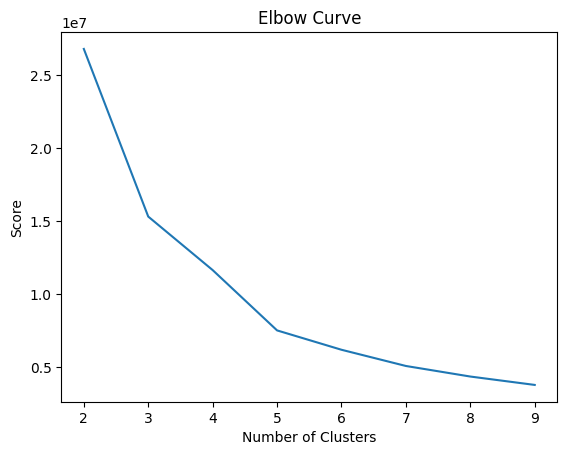

In [0]:
from pyspark.mllib.clustering import StreamingKMeans
from pyspark.ml.clustering import KMeans

position_vectorizer = VectorAssembler(inputCols=['PosX', 'PosY'], outputCol='features')

cost = np.zeros(10)
models = []
for k in range(2,10):
    means = KMeans().setK(k).setSeed(1)
    model = means.fit(position_vectorizer.transform(test_df))
    cost[k] = model.summary.trainingCost
    models.append(model)

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8,9]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [0]:
best_clustered = models[3].summary.predictions
display(best_clustered)

PosX PosY VelX VelY Action ActionIndex features prediction 90.0 542.0 0.0 81.0 none 0.0 Map(vectorType -> dense, length -> 2, values -> List(90.0, 542.0)) 1 90.0 549.0 0.0 0.0 none 0.0 Map(vectorType -> dense, length -> 2, values -> List(90.0, 549.0)) 1 90.0 549.0 0.0 0.0 none 0.0 Map(vectorType -> dense, length -> 2, values -> List(90.0, 549.0)) 1 90.0 549.0 0.0 0.0 none 0.0 Map(vectorType -> dense, length -> 2, values -> List(90.0, 549.0)) 1 90.0 549.0 0.0 0.0 none 0.0 Map(vectorType -> dense, length -> 2, values -> List(90.0, 549.0)) 1 110.0 549.0 300.0 0.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(110.0, 549.0)) 1 135.0 549.0 300.0 0.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(135.0, 549.0)) 1 160.0 549.0 300.0 0.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(160.0, 549.0)) 1 185.0 549.0 300.0 0.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(185.0, 549.0)) 1 210.0 549.0 300.0 0.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(210.0, 549.0)) 1 235.0 549.0 300.0 0.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(235.0, 549.0)) 1 260.0 549.0 300.0 0.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(260.0, 549.0)) 1 285.0 543.0 300.0 -400.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(285.0, 543.0)) 1 310.0 514.0 300.0 -318.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(310.0, 514.0)) 1 335.0 491.0 300.0 -236.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(335.0, 491.0)) 1 360.0 475.0 300.0 -154.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(360.0, 475.0)) 1 385.0 467.0 300.0 -73.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(385.0, 467.0)) 3 410.0 465.0 300.0 8.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(410.0, 465.0)) 3 435.0 469.0 300.0 90.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(435.0, 469.0)) 3 460.0 481.0 300.0 171.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(460.0, 481.0)) 3 485.0 489.0 300.0 0.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(485.0, 489.0)) 3 510.0 476.0 300.0 -383.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(510.0, 476.0)) 3 535.0 448.0 300.0 -301.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(535.0, 448.0)) 3 560.0 427.0 300.0 -220.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(560.0, 427.0)) 3 585.0 413.0 300.0 -138.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(585.0, 413.0)) 4 610.0 406.0 300.0 -56.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(610.0, 406.0)) 4 635.0 405.0 300.0 24.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(635.0, 405.0)) 4 660.0 411.0 300.0 106.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(660.0, 411.0)) 4 685.0 424.0 300.0 188.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(685.0, 424.0)) 4 710.0 444.0 300.0 269.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(710.0, 444.0)) 4 735.0 450.0 300.0 -400.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(735.0, 450.0)) 4 760.0 421.0 300.0 -318.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(760.0, 421.0)) 0 785.0 404.0 300.0 16.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(785.0, 404.0)) 0 798.0 409.0 0.0 98.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(798.0, 409.0)) 0 798.0 422.0 0.0 179.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(798.0, 422.0)) 0 798.0 441.0 0.0 261.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(798.0, 441.0)) 0 798.0 456.0 0.0 0.0 MoveRight 2.0 Map(vectorType -> dense, length -> 2, values -> List(798.0, 456.0)) 0 798.0 456.0 0.0 0.0 M

In [0]:
def visualize_coordinates_clustered(df, class_col="prediction"):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    colors = ["r", "g", "b", "y", "c"]

    for class_id, color in zip(range(6), colors):
        class_data = df[df[class_col] == class_id]
        ax.scatter(class_data['PosX'], class_data['PosY'], c=color, label=f'Cluster {class_id}')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    ax.legend()

    plt.show()

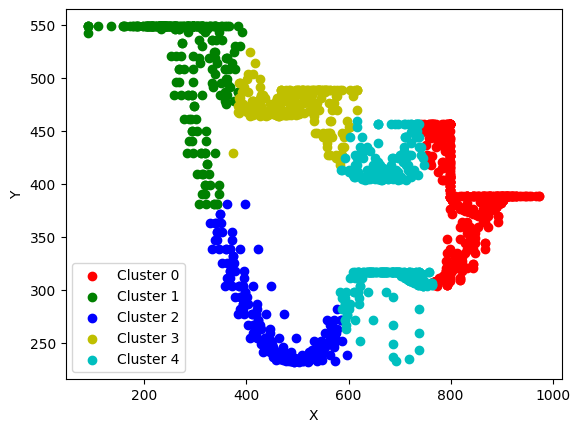

In [0]:
visualize_coordinates_clustered(best_clustered.toPandas())

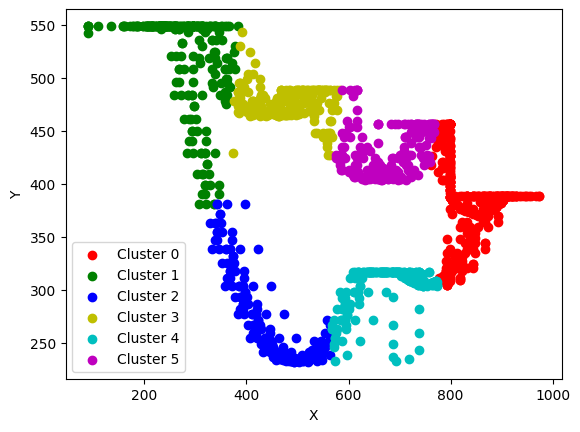

In [0]:
df_clustered2 = models[4].summary.predictions.toPandas()
fig = plt.figure()
ax = fig.add_subplot(111)
colors = ["r", "g", "b", "y", "c", "m"]
class_col = "prediction"
for class_id, color in zip(range(7), colors):
    class_data = df_clustered2[df_clustered2[class_col] == class_id]
    ax.scatter(class_data['PosX'], class_data['PosY'], c=color, label=f'Cluster {class_id}')

ax.set_xlabel('X')
ax.set_ylabel('Y')

ax.legend()

plt.show()